# 读取图片

In [164]:
import matplotlib.pyplot as plt  
import tensorflow as tf  
import numpy as np  
import os, sys
import math

### 返回的是两个list，一个是文件路径，一个是标签

In [165]:
def get_files(path):
    class_train = []
    label_train = []
    for train_class in os.listdir(path):
        for pic in os.listdir(path+train_class):
            class_train.append(path+train_class+'/'+pic) #class_train获得的是文件的的list“路径+类型+文件名”
            label_train.append(train_class)                 #label_train获得的是分类class的list “left/right”
    temp = np.array([class_train,label_train])  # 2*140
    #print(temp.shape)
    temp = temp.transpose()  # 140*2
    #打乱顺序
    np.random.shuffle(temp)
    #第一列是image，第二列是label
    image_list = list(temp[:,0])
    label_list = list(temp[:,1])
    label_list = [int(i) for i in label_list]
    #print(label_list)
    return image_list,label_list

In [166]:
# 打开文件
path = "C:/Users/DELL/Desktop/EEG_cwt/"
image_list,label_list=get_files(path)

In [192]:
#image_list[0:5]
#label_list[0:5]

## 生成X
### 将图片调整到统一大小

In [169]:
X=np.empty([140,64,64,3], dtype=int)

In [170]:
with tf.Session() as sess: 
    for i in range(140):
        image_raw_data = tf.gfile.GFile(image_list[i],'r').read() 
        img_data = tf.image.decode_jpeg(image_raw_data)  
        
        #第一个参数为原始图像，第二个参数为图像大小，第三个参数给出了指定的算法  
        resized = tf.image.resize_images(img_data, [64,64],method=0)  
        resized = np.asarray(resized.eval(),dtype='uint8') 
        X[i,:,:,:]=resized 
        

### X_train  /  X_test

In [172]:
X_train=X[0:90,:,:,:]
X_test=X[90:140,:,:,:]

## 生成Y

In [201]:
Y=np.array(label_list)-1
Y=Y.reshape([140,1])

### 将标签编码

In [202]:
oh = tf.one_hot(Y, depth = 2,  on_value = 1 , off_value = 0, axis = -1)
sess = tf.Session()
Y=sess.run(oh)
sess.close()

In [203]:
Y=Y.reshape([140,2])

### Y_train  /  Y_test

In [204]:
Y_train=Y[0:90,:]
Y_test=Y[90:140,:]

In [205]:
X_train = X_train/255.
X_test = X_test/255.
#Y_train = convert_to_one_hot(Y_train_orig, 6).T
#Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
#conv_layers = {}

number of training examples = 90
number of test examples = 50
X_train shape: (90, 64, 64, 3)
Y_train shape: (90, 2)
X_test shape: (50, 64, 64, 3)
Y_test shape: (50, 2)


#### 生成placeholder

In [208]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """   
    Arguments:
    n_H0 -- 标量，输入图像的高度
    n_W0 -- 标量，输入图像的宽度
    n_C0 -- 标量，输入的通道数
    n_y  -- 标量，类别数目
        
    Returns:
    X -- 特征的placeholder, [None, n_H0, n_W0, n_C0] ,类型 "float"
    Y -- 标签的placeholder, [None, n_y] ，类型 "float"
    """
    X = tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32,shape=(None,n_y))
    
    return X, Y

#### 初始化参数

In [209]:
def initialize_parameters():
    """
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]   
   """                                      
    W1 = tf.get_variable('W1',shape=(4,4,3,8),initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',shape=(2,2,8,16),initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [210]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [-0.0752826   0.08046506 -0.18115364  0.01793462 -0.11417466 -0.15131985
 -0.1336818  -0.06460937]
W2 = [ 0.18771225  0.02089775  0.00491112 -0.12298661 -0.04200333  0.13979024
  0.05375856 -0.10530782 -0.15856427  0.19796973  0.04295498 -0.0471608
  0.01342118  0.21189791  0.1855194  -0.13519925]


#### 前向传播

In [211]:
def forward_propagation(X, parameters):
    """
    前向传播过程
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- 输入 placeholder, (input size, number of examples)
    parameters -- "W1", "W2"

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    #第一个参数input：指需要做卷积的输入图像，具有[batch, in_height, in_width, in_channels]这样的shape，
    #具体含义是[训练时一个batch的图片数量, 图片高度, 图片宽度, 图像通道数]，
    #注意这是一个4维的Tensor，要求类型为float32和float64其中之一
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    # 2个输出单元（2分类）
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=2,activation_fn=None)
    
    return Z3

#### 获得梯度下降的minibatch

In [212]:
    def random_mini_batches(X, Y, mini_batch_size =10, seed = 0): 
        m = X.shape[0]                  # number of training examples 
        mini_batches = [] 
        np.random.seed(seed) 
        #Y=Y.T         #(1080,6) 
        # Step 1: Shuffle (X, Y) 
        permutation = list(np.random.permutation(m))   #从0到m打乱的序列
        shuffled_X = X[permutation,:,:,:] 
        shuffled_Y = Y[permutation,:]#.reshape((m,Y.shape[1])) 
     
        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case. 
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning 
        for k in range(0, num_complete_minibatches): 
            mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:] 
            mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:] 
            mini_batch = (mini_batch_X, mini_batch_Y) 
            mini_batches.append(mini_batch) 
         
        # Handling the end case (last mini-batch < mini_batch_size) 
        if m % mini_batch_size != 0: 
            mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:] 
            mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:] 
            mini_batch = (mini_batch_X, mini_batch_Y) 
            mini_batches.append(mini_batch) 
         
        return mini_batches

In [216]:
import math
mini_batches=random_mini_batches(X_train, Y_train, mini_batch_size = 5, seed = 0)

In [217]:
len(mini_batches)

18

### 计算代价

In [218]:
def compute_cost(Z3, Y):
    """    
    Arguments:
    Z3 -- (6, number of examples)
    Y -- 真实标签
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

## 组织模型

In [239]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 300, minibatch_size = 8, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(64, 64, 3, 2)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost] , feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

## 训练

Cost after epoch 0: 0.758663
Cost after epoch 5: 0.756442
Cost after epoch 10: 0.754578
Cost after epoch 15: 0.741233
Cost after epoch 20: 0.716164
Cost after epoch 25: 0.677490
Cost after epoch 30: 0.645406
Cost after epoch 35: 0.580447
Cost after epoch 40: 0.544644
Cost after epoch 45: 0.542436
Cost after epoch 50: 0.524556
Cost after epoch 55: 0.499241
Cost after epoch 60: 0.483994
Cost after epoch 65: 0.451545
Cost after epoch 70: 0.446414
Cost after epoch 75: 0.450028
Cost after epoch 80: 0.448721
Cost after epoch 85: 0.433235
Cost after epoch 90: 0.395610
Cost after epoch 95: 0.401371
Cost after epoch 100: 0.368835
Cost after epoch 105: 0.414434
Cost after epoch 110: 0.371673
Cost after epoch 115: 0.329650
Cost after epoch 120: 0.330940
Cost after epoch 125: 0.318260
Cost after epoch 130: 0.340229
Cost after epoch 135: 0.334510
Cost after epoch 140: 0.291291
Cost after epoch 145: 0.299233
Cost after epoch 150: 0.279465
Cost after epoch 155: 0.281213
Cost after epoch 160: 0.279132

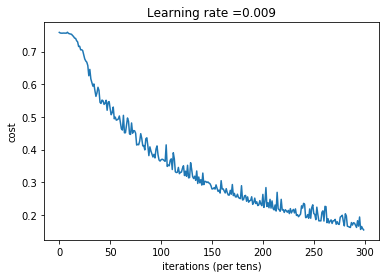

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9444444
Test Accuracy: 0.86


In [240]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)